In [55]:
import numpy as np
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss
from torchmetrics import R2Score
import json
from glob import glob

import umap
import torch
import pandas as pd
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.model.gated_reaction_network_lightning import (
    GatedGCNReactionNetworkLightning,
)
from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import (
    evaluate_breakdown,
    get_grapher,
    load_model_lightning,
)
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss

In [2]:
def get_dataset(
    train_path="../../dataset/Training_set_HEPoP_after_filtering.json",
    test_path="../../dataset/Holdout_test_set_HEPoP_after_filtering.json",
):
    # train_df_path = "../../dataset/Training_set_HEPoP_after_filtering.json"
    # test_df_path = "/home/rdguha95/Holdout_test_set_HEPoP_after_filtering.json"
    train_df = pd.read_json(train_path)
    test_df = pd.read_json(test_path)
    frames = [train_df, test_df]
    full_df = pd.concat(frames)
    full_df.reset_index(inplace=True)
    full_df.drop(columns="index", inplace=True)
    full_df = full_df.drop_duplicates(subset=["reaction_id"])
    full_df = full_df.reset_index(drop=True)
    return full_df, test_df, train_df


full_df, test_df, train_df = get_dataset()

In [3]:
torch.set_float32_matmul_precision("high")
from bondnet.test_utils import get_defaults

config = get_defaults()
config["extra_features"] = ["bond_length"]

In [4]:
dataset = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(config["model"]["extra_features"]),
    file="../../dataset/Holdout_test_set_HEPoP_after_filtering.json",
    target="dG_sp",
    classifier=False,
    classif_categories=3,
    filter_species=[3, 6],
    filter_outliers=False,
    filter_sparse_rxns=False,
    debug=False,
    extra_keys=config["model"]["extra_features"],
    extra_info=["functional_group_reacted"],
    species=["C", "F", "H", "N", "O", "Mg", "Li", "S", "Cl", "P", "O", "Br"],
)
test_dataset_loader = DataLoaderReactionNetwork(
    dataset, batch_size=len(dataset), shuffle=False
)

reading file from: ../../dataset/Holdout_test_set_HEPoP_after_filtering.json
rxn raw len: 1000
Program finished in 11.731687723000505 seconds
.............failures.............
reactions len: 1000
valid ind len: 1000
bond break fail count: 		0
default fail count: 		0
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 1000
features: 2642
labels: 1000
molecules: 2642
constructing graphs & features....
number of graphs valid: 2642
number of graphs: 2642


In [20]:
model_list = glob("./embedding_models/*.ckpt")
model_list.sort()
print(model_list)
# put the last model first

['./embedding_models/model_epoch_epoch=19.ckpt', './embedding_models/model_epoch_epoch=29.ckpt', './embedding_models/model_epoch_epoch=39.ckpt', './embedding_models/model_epoch_epoch=9.ckpt', './embedding_models/untrained.ckpt']


In [21]:
model_list_ordered = [
    "./embedding_models/untrained.ckpt",
    "./embedding_models/model_epoch_epoch=9.ckpt",
    "./embedding_models/model_epoch_epoch=19.ckpt",
    "./embedding_models/model_epoch_epoch=29.ckpt",
    "./embedding_models/model_epoch_epoch=39.ckpt",
]

In [22]:
model_list = []

for model_path in model_list_ordered:
    config["restore"] = True
    # model_path = "./top_models/model_lightning_epoch=208-val_l1=1.94.ckpt"
    config["restore_path"] = model_path
    model_restart = load_model_lightning(config, load_dir=model_path)
    # load model to gpu
    model_restart.cuda()
    model_list.append(model_restart)

:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
:::MODEL LOADED:::
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
:::MODEL LOADED:::
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
:::MODEL LOADED:::
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
:::MODEL LOADED:::
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
:::MODEL LOADED:::


In [29]:
def get_embeddings(model_restart, data_loader, device):
    # get
    embedding_list = []
    label_list = []
    functional_group_list = []
    nodes = ["atom", "bond", "global"]
    embedding_size = model_restart.hparams.embedding_size
    batch_size = len(data_loader)

    direct_concat_name = model_restart.hparams.set2set_ntypes_direct
    gat_out = model_restart.hparams.gated_hidden_size[-1]
    readout_out_size = gat_out * 2 + gat_out * 2
    readout_out_size += gat_out * len(direct_concat_name)

    for it, (batched_graph, label) in enumerate(data_loader):
        batched_graph = batched_graph.to(device)
        feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
        target = label["value"]
        norm_atom = label["norm_atom"]
        # norm_atom = None
        norm_bond = label["norm_bond"]
        # norm_bond = None
        stdev = label["scaler_stdev"]

        if device is not None:
            feats = {k: v.to(device) for k, v in feats.items()}
            target = target.to(device)
            norm_atom = norm_atom.to(device)
            norm_bond = norm_bond.to(device)
            stdev = stdev.to(device)
        reactions = label["reaction"]

        functional_group_temp = [
            i.extra_info["functional_group_reacted"] for i in reactions
        ]
        functional_group_list.append(functional_group_temp)

        embeddings = model_restart.feature_before_fc(
            graph=batched_graph,
            feats=feats,
            reactions=reactions,
            norm_atom=norm_atom,
            norm_bond=norm_bond,
        )

        # add to embedding list
        numpy_embeddings = embeddings.detach().cpu().numpy()
        embedding_list.append(numpy_embeddings)

    return embedding_list, functional_group_list


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_lists = []
funct_list = []
for model in model_list:
    embedding_list, functional_group_list = get_embeddings(
        model, test_dataset_loader, device
    )
    embedding_lists.append(embedding_list)
    funct_list.append(functional_group_list)

In [50]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(np.array(funct_list[0]).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [51]:
def get_one_hot_encoding(enc, functional_group_list):
    functional_group_list = np.array(functional_group_list).reshape(-1, 1)
    return enc.transform(functional_group_list)


funct_one_hot = [get_one_hot_encoding(enc, i) for i in funct_list]
funct_one_hot_array = [i.toarray() for i in funct_one_hot]
funct_non_one_hot = [np.argmax(i, axis=1) for i in funct_one_hot_array]

In [53]:
# Define the custom color list
custom_colors = [
    sns.xkcd_rgb["french blue"],
    sns.xkcd_rgb["light green"],
    sns.xkcd_rgb["tomato"],
    sns.xkcd_rgb["brown"],
    sns.xkcd_rgb["orange"],
    sns.xkcd_rgb["burnt yellow"],
    sns.xkcd_rgb["sky blue"],
    sns.xkcd_rgb["light rose"],
    sns.xkcd_rgb["violet"],
    sns.xkcd_rgb["light magenta"],
]


def parition_by_label(umap_raw, partition_labels):
    """
    Partition UMAP embedding by labels
    """
    dict_partition = {}
    for i in np.unique(partition_labels):
        dict_partition[i] = umap_raw[partition_labels == i]
    return dict_partition


def plot_partitioned_umap(partitioned_umap, labels):
    """
    Plot partitioned UMAP embedding
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Use the custom color list for plotting
    for ind, i in enumerate(partitioned_umap.keys()):
        color = custom_colors[
            ind % len(custom_colors)
        ]  # Cycle through the custom colors
        ax.scatter(
            partitioned_umap[i][:, 0],
            partitioned_umap[i][:, 1],
            label=labels[ind],
            color=color,
        )

    legend = ax.legend(loc="lower right", title="Functional Group Reacted")

    # Customize legend title appearance
    legend.get_title().set_fontsize("12")  # Set font size
    legend.get_title().set_fontweight("bold")  # Set font weight

    ax.set_yticklabels(ax.get_yticks(), size=15, weight="bold")
    ax.set_xticklabels(ax.get_xticks(), size=15, weight="bold")

    return fig, ax

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

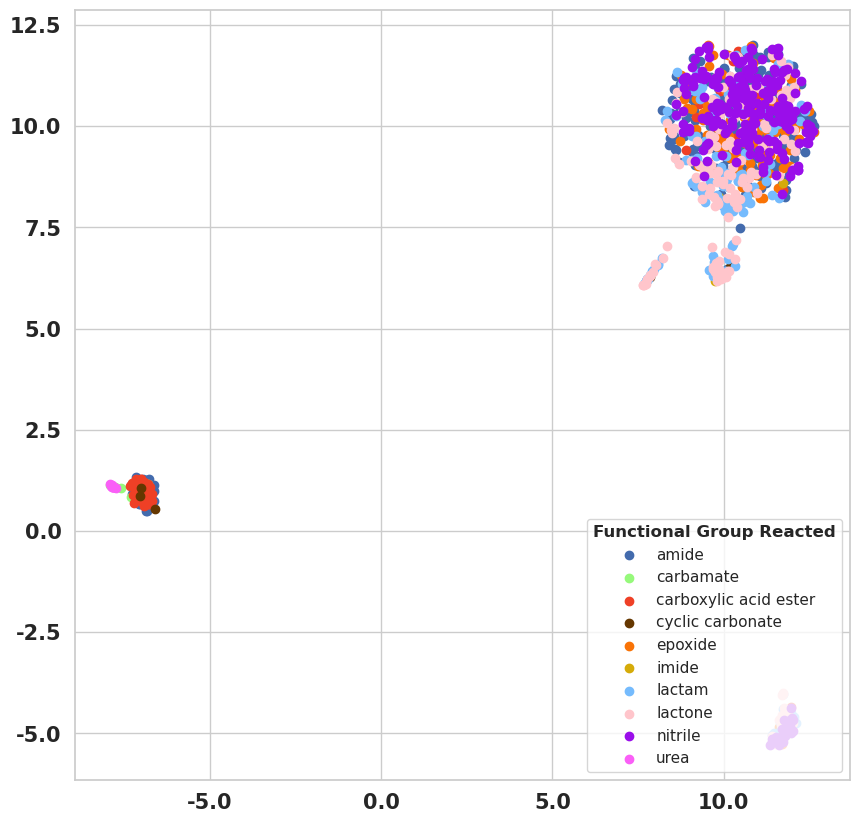

In [61]:
model_ind = 0
fit = umap.UMAP()
u = fit.fit_transform(embedding_lists[model_ind][0])
partitioned_umap = parition_by_label(u, funct_non_one_hot[model_ind])
plot_partitioned_umap(partitioned_umap, enc.categories_[0])

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

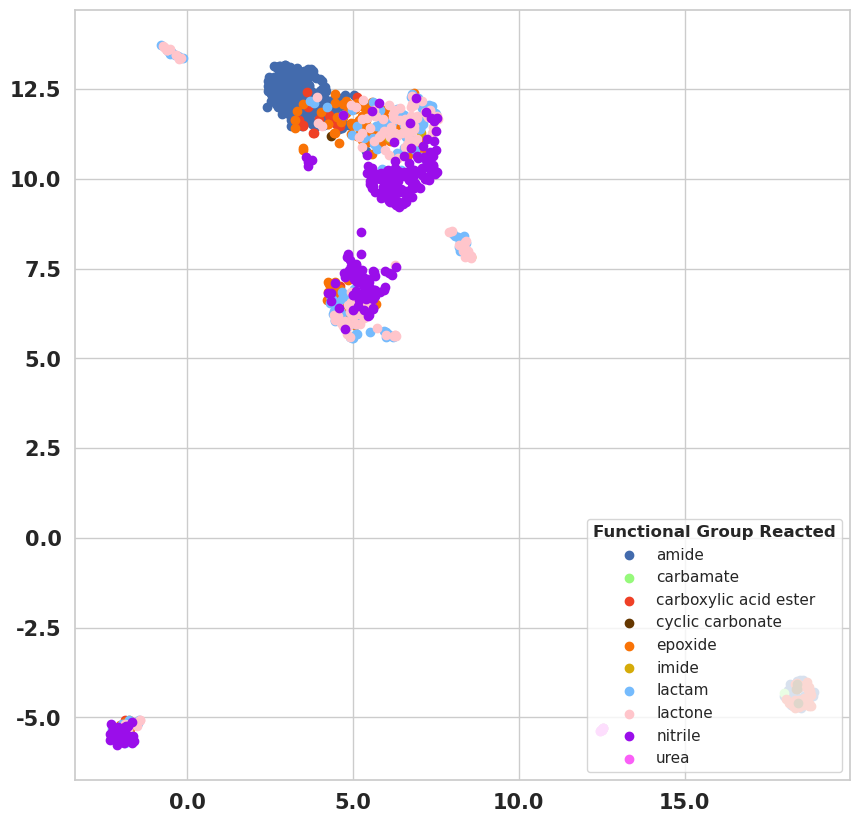

In [62]:
model_ind = 1
fit = umap.UMAP()
u = fit.fit_transform(embedding_lists[model_ind][0])
partitioned_umap = parition_by_label(u, funct_non_one_hot[model_ind])
plot_partitioned_umap(partitioned_umap, enc.categories_[0])

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

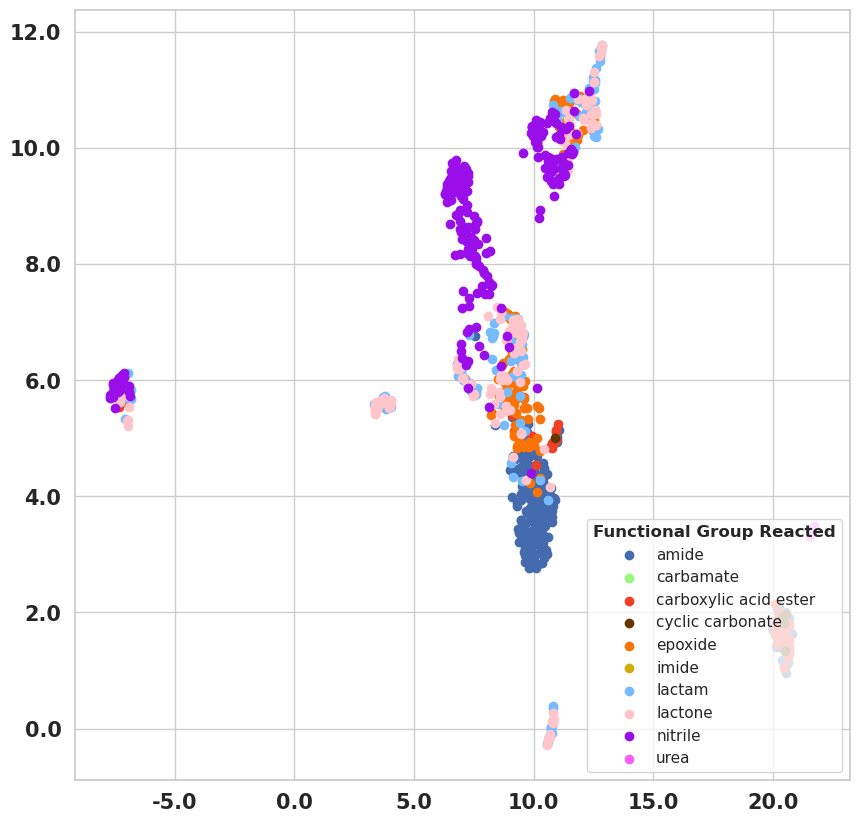

In [63]:
model_ind = 2
fit = umap.UMAP()
u = fit.fit_transform(embedding_lists[model_ind][0])
partitioned_umap = parition_by_label(u, funct_non_one_hot[model_ind])
plot_partitioned_umap(partitioned_umap, enc.categories_[0])

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

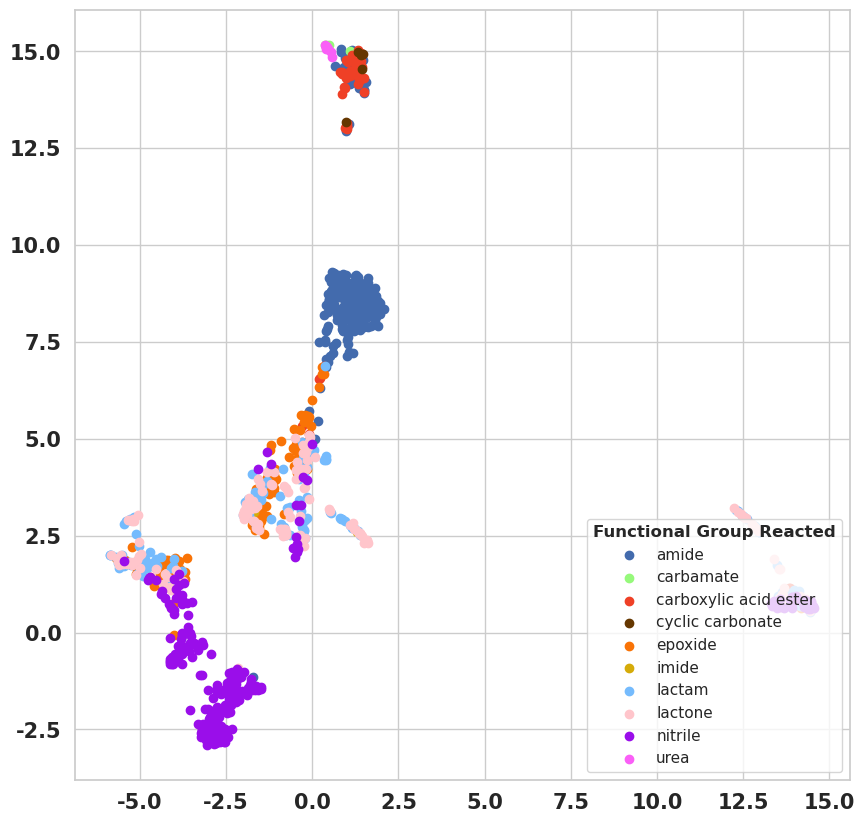

In [64]:
model_ind = 3
fit = umap.UMAP()
u = fit.fit_transform(embedding_lists[model_ind][0])
partitioned_umap = parition_by_label(u, funct_non_one_hot[model_ind])
plot_partitioned_umap(partitioned_umap, enc.categories_[0])

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator


(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

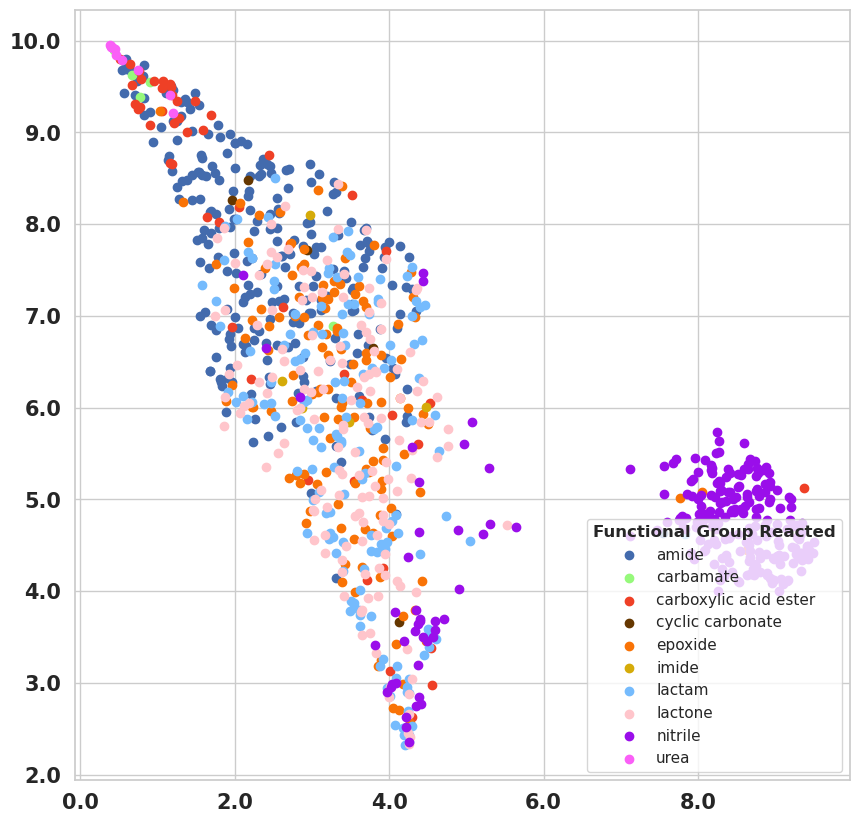

In [65]:
model_ind = 4
fit = umap.UMAP()
u = fit.fit_transform(embedding_lists[model_ind][0])
partitioned_umap = parition_by_label(u, funct_non_one_hot[model_ind])
plot_partitioned_umap(partitioned_umap, enc.categories_[0])